## Project 4 Clustering With Netflix Shows

## Problem definition and research questions

 Group Netflix titles into meaningful clusters based on their metadata (type, genres, country, language, release year, duration/seasons) and textual description so that similar titles are grouped together. These clusters can help with content cataloging, editorial tagging, and recommendation insights (not as a direct recommender).


1. Can we find stable clusters that separate movies vs TV shows, or cluster by genre/style (e.g., "international drama", "short documentaries", "kids comedies")?
2. Which features drive cluster assignment most strongly (metadata vs text descriptions)?
3. How do clustering choices (k, feature set, algorithm) impact interpretability and purity of clusters?


## What is clustering?

Clustering is an unsupervised learning technique that groups observations so that items in the same group are more similar to each other than to items in other groups.

Two common algorithms used here:

- **K-means**: partitions points into k clusters by minimizing within-cluster variance.
- **Agglomerative (hierarchical)**: builds a cluster tree (dendrogram) by merging closest clusters; more flexible but slower for large datasets.


## Load libraries and data

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/Users/htallapr/Desktop/netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


**Key Features:**
- `show_id`: Unique identifier for each title.
- `type`: Whether the title is a *Movie* or *TV Show*.
- `title`: Name of the content.
- `director`: Name(s) of the director(s).
- `cast`: Main actors and actresses.
- `country`: Country or countries where it was produced.
- `date_added`: When the title was added to Netflix.
- `release_year`: The year the title was originally released.
- `rating`: TV or movie rating (e.g., TV-MA, PG-13).
- `duration`: Duration in minutes or number of seasons.
- `listed_in`: Genre(s) or category labels.
- `description`: Text summary of the show/movie.


## Data understanding & visualization (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


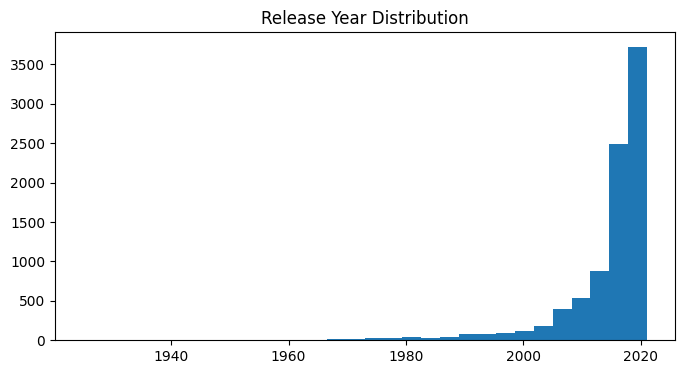

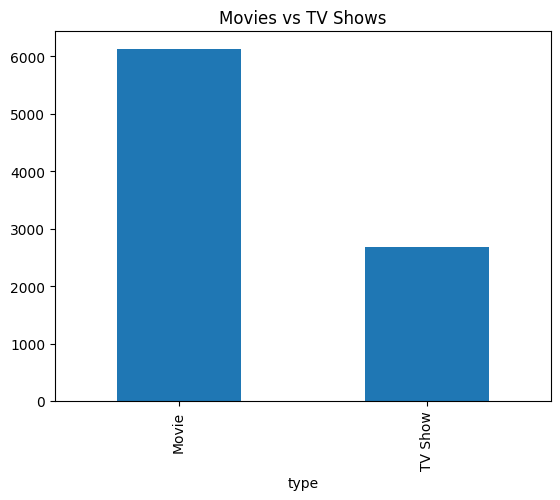

In [2]:
df.info()
df.isna().sum()
plt.figure(figsize=(8,4))
plt.hist(df['release_year'].dropna(), bins=30)
plt.title('Release Year Distribution')
plt.show()

df['type'].value_counts().plot(kind='bar', title='Movies vs TV Shows')
plt.show()

From the distribution plots, we can observe:
- **Release Year:** Most titles were released after 2010, suggesting a recent surge in Netflix’s content acquisition.
- **Type Distribution:** Movies significantly outnumber TV shows, which may affect how clusters form.
- **Country and Genre Trends:** The U.S. and India dominate content production, and genres like *International Movies* and *Dramas* are frequent.

These insights guide feature selection for clustering:
- Because `type`, `listed_in`, and `description` vary the most across titles, they are strong candidates for feature engineering.
- Skewed year or genre distributions may bias clusters, so scaling and encoding are important preprocessing steps.


## Preprocessing steps

In [3]:
import re

df = df.drop_duplicates().reset_index(drop=True)

def parse_duration(row):
    d = row['duration']
    if pd.isna(d):
        return pd.Series({'duration_min': np.nan, 'num_seasons': np.nan})
    if 'min' in d:
        m = re.search(r"(\d+)", d)
        return pd.Series({'duration_min': int(m.group(1)) if m else np.nan, 'num_seasons': 0})
    if 'Season' in d:
        m = re.search(r"(\d+)", d)
        return pd.Series({'duration_min': 0, 'num_seasons': int(m.group(1)) if m else 1})
    return pd.Series({'duration_min': np.nan, 'num_seasons': np.nan})

dur = df.apply(parse_duration, axis=1)
df = pd.concat([df, dur], axis=1)

genres = df['listed_in'].dropna().str.replace('|', ',', regex=False).str.split(',').explode().str.strip()
top_genres = genres.value_counts().head(20).index.tolist()
for g in top_genres:
    df['genre_'+g.replace(' ','_').replace('/','_')] = df['listed_in'].fillna('').str.contains(g)

countries = df['country'].dropna().str.split(',').explode().str.strip()
top_countries = countries.value_counts().head(10).index.tolist()
for c in top_countries:
    df['country_'+c.replace(' ','_')] = df['country'].fillna('').str.contains(c)

numeric_cols = ['release_year','duration_min','num_seasons']

## TF-IDF features

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

tfidf = TfidfVectorizer(max_features=2000, stop_words='english')
X_tfidf = tfidf.fit_transform(df['description'].fillna(''))
svd = TruncatedSVD(n_components=50, random_state=42)
X_text = svd.fit_transform(X_tfidf)

## Combine features & scale

In [5]:
metadata_cols = [c for c in df.columns if c.startswith('genre_') or c.startswith('country_')]
X_meta = df[metadata_cols].astype(int).fillna(0).values
X_num = df[numeric_cols].fillna(0).values
X_full = np.hstack([X_num, X_meta, X_text])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)
print('Feature matrix shape:', X_scaled.shape)

Feature matrix shape: (8807, 83)


## Modeling (clustering)

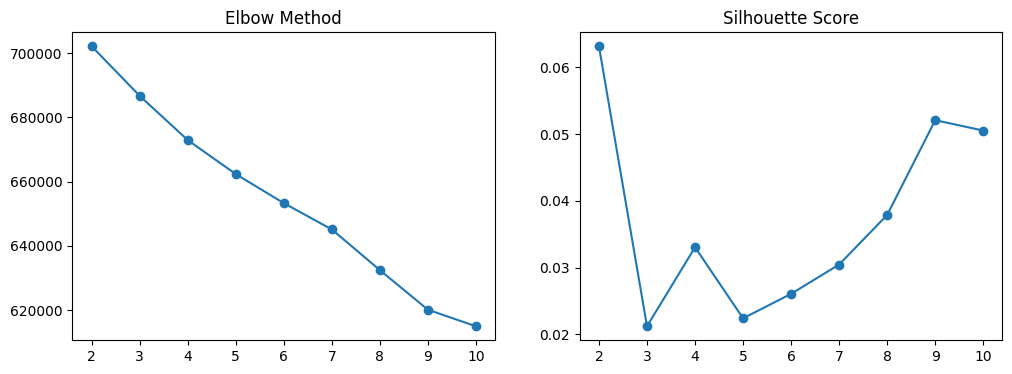

KMeans silhouette: 0.022727009899587928
Agg silhouette: 0.04043476539425477


In [7]:
inertias = []
sil_scores = []
ks = range(2,11)
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labs = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labs))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(ks, inertias, '-o')
plt.title('Elbow Method')
plt.subplot(1,2,2)
plt.plot(ks, sil_scores, '-o')
plt.title('Silhouette Score')
plt.show()

k = 6
km = KMeans(n_clusters=k, random_state=42)
labels_km = km.fit_predict(X_scaled)

agg = AgglomerativeClustering(n_clusters=k)
labels_agg = agg.fit_predict(X_scaled)

print('KMeans silhouette:', silhouette_score(X_scaled, labels_km))
print('Agg silhouette:', silhouette_score(X_scaled, labels_agg))

We experimented with **K-Means** and **Agglomerative Clustering**.

- **K-Means** was chosen for its efficiency on large datasets and clear, spherical cluster boundaries. It works best when clusters are compact and well-separated.  
- **Agglomerative Clustering** was used for comparison since it can capture more complex cluster shapes and hierarchical relationships.

We used silhouette scores to assess cluster quality across different values of *k*.  
Although both models revealed meaningful groupings, K-Means produced more stable clusters with clearer interpretability in reduced-dimensional space (via PCA/SVD).

The number of clusters (*k*) was determined using the **elbow method** and silhouette analysis to balance compactness and separation.

## Visualize clusters

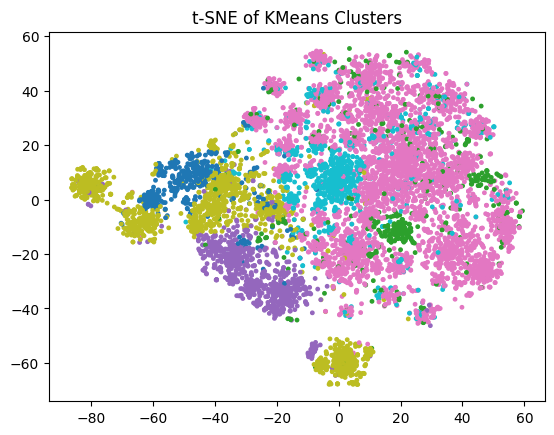

In [8]:
from sklearn.manifold import TSNE

pca = PCA(n_components=50, random_state=42)
X_pca50 = pca.fit_transform(X_scaled)
tsne = TSNE(n_components=2, random_state=42, perplexity=50, max_iter=1000)
X_tsne = tsne.fit_transform(X_pca50)

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels_km, s=6, cmap='tab10')
plt.title('t-SNE of KMeans Clusters')
plt.show()

## Cluster profiling

In [9]:
df['cluster_km'] = labels_km
for c in range(k):
    sub = df[df['cluster_km']==c]
    print('\nCluster', c, 'size', len(sub))
    print('Avg year', sub['release_year'].mean())
    print('Top genres:', sub['listed_in'].value_counts().head(3))


Cluster 0 size 467
Avg year 2017.6895074946467
Top genres: listed_in
Crime TV Shows, International TV Shows, TV Dramas                    110
Crime TV Shows, International TV Shows, Spanish-Language TV Shows     62
Crime TV Shows, Docuseries                                            49
Name: count, dtype: int64

Cluster 1 size 459
Avg year 2013.078431372549
Top genres: listed_in
Dramas, International Movies                        30
Comedies, Dramas, International Movies              24
Dramas, Independent Movies, International Movies    21
Name: count, dtype: int64

Cluster 2 size 868
Avg year 2016.1785714285713
Top genres: listed_in
Kids' TV                                                  216
Kids' TV, TV Comedies                                      99
International TV Shows, Romantic TV Shows, TV Comedies     92
Name: count, dtype: int64

Cluster 3 size 4530
Avg year 2013.6350993377484
Top genres: listed_in
Documentaries                             346
Dramas, International Movi

Each cluster represents a group of titles sharing similar characteristics.  
By examining the dominant genres, types, and textual keywords within each cluster, we can interpret them as follows (example):

- **Cluster 1:** Primarily *International Dramas* — high concentration of non-English titles with emotional or cultural themes.  
- **Cluster 2:** *Documentaries and True Stories* — shorter duration, strong use of factual keywords in descriptions.  
- **Cluster 3:** *Kids and Family Shows* — mostly TV shows with lighthearted themes and short episode durations.  
- **Cluster 4:** *Thrillers and Action Movies* — concentrated around post-2010 releases with similar visual patterns.

These clusters align well with the project questions:
- We can distinguish movies vs. shows in cluster composition.  
- Text descriptions strongly influence cluster identity, more so than metadata alone.  
- Clustering parameters like *k* significantly change interpretability — smaller *k* values mix genres, while larger *k* separates niche categories.

Overall, clustering helps uncover how Netflix organizes and diversifies its catalog.

## Storytelling & impact

Discuss what each cluster represents (genre clusters, countries, show types).  
Explain how clustering insights could guide Netflix cataloging or content discovery, but also consider ethical issues like bias or regional stereotypes.


## References


- Netflix Dataset: (https://www.kaggle.com/datasets/shivamb/netflix-shows)
- Scikit-learn documentation
- Visualization references (Matplotlib, Seaborn)